In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from itertools import combinations
from sklearn.cluster import MeanShift
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression

In [70]:
# Bug in VS Code makes you change the directory
base_path = '/home/petehillyard/xandem_projects/personal_research'
os.chdir(base_path + '/ml-exploration/iris')
df = pd.read_csv('data/bezdekIris.data')
df.head(3)

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa


# Pairwise relationships
We'll start by looking at pairwise relationships between features.

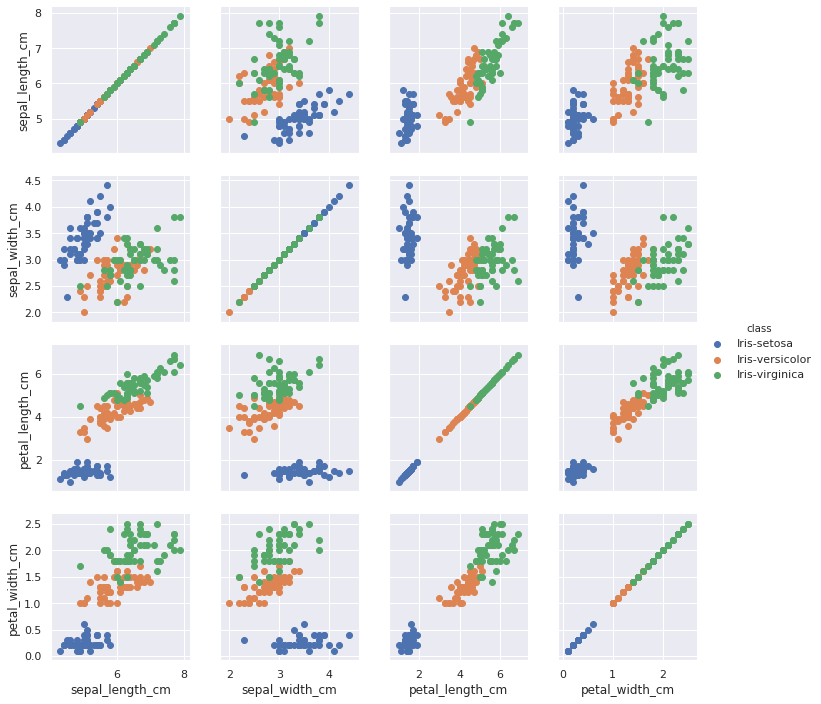

In [71]:
g = sns.PairGrid(df, hue='class');
g = g.map(plt.scatter);
g = g.add_legend()

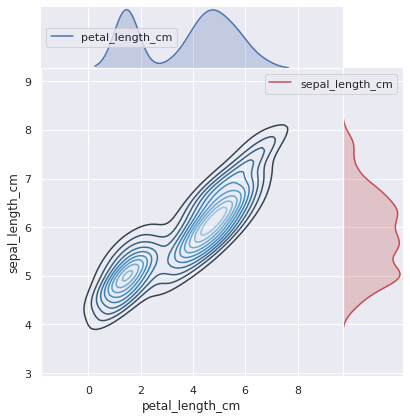

In [92]:
g = sns.JointGrid(x='petal_length_cm', y='sepal_length_cm', data=df, space=0);
g = g.plot_joint(sns.kdeplot, cmap='Blues_d');
sns.kdeplot(df['petal_length_cm'], color='b', shade=True, bw=0.25, ax=g.ax_marg_x);
sns.kdeplot(df['sepal_length_cm'], color='r', shade=True, bw=0.25, vertical=True, ax=g.ax_marg_y);

## Clustering with no knowledge of the number of classes
Let's start by thinking about what will happen if we try to use a clustering algorithm that does not know the number of classes. It's pretty evident from the plots that a clustering algorithm will be able to perfectly cluster the Iris-setosa based on `petal_length_cm` and `petal_width_cm`. This class, using these two features, is linearly separable from Iris-versicolor and Iris-virginica. Yet, it doesn't look like there would be a clustering algorithm that could separate Iris-versicolor and Iris-virginica. No matter which feature is chosen, this is significant overlap in the data and there doesn't appear to be two distinct modes. A clustering algorithm (with no knowledge of the number of classes) is looking for distinct groups of data with either enough mass near the mean or enough separation between groups to cut a line between the data. Let's implement a few of these clustering algorithms to see how they do.

### Run mean shift
We'll start by running the mean shift clustering algorithm. I was surprised to find that mean shift algorithm was able to separate the Iris-versicolor and Iris-virginica classes. I wasn't able to initially see the significant masses for each group, but they were there. But it was clear that you had to choose the right bandwidth otherwise the two irises became one cluster or multiple clusters. One other small improvement was scaling the data to be zero mean and unit variance.

[[-0.82514286 -0.70266667]
 [ 0.0393586   0.09659864]
 [ 0.30544218  0.46984127]]
{(0, 'Iris-setosa'): 50, (1, 'Iris-versicolor'): 49, (2, 'Iris-versicolor'): 1, (2, 'Iris-virginica'): 46, (1, 'Iris-virginica'): 4}


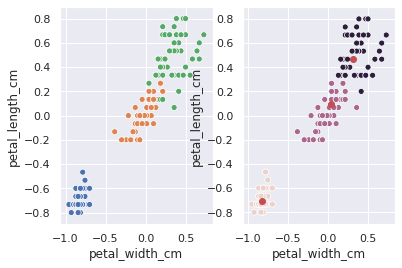

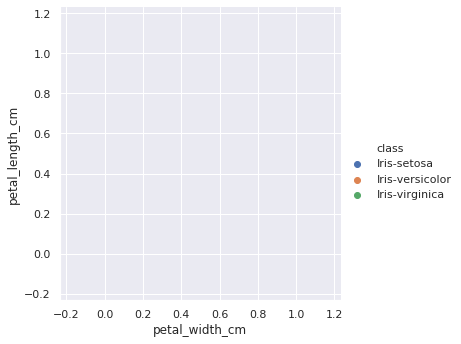

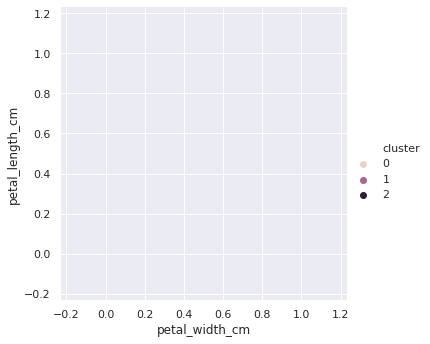

In [102]:
d = {key: df[key] for key in ['petal_width_cm', 'petal_length_cm', 'class']}
df_p = pd.DataFrame(data=d)
X = df_p[['petal_length_cm', 'petal_width_cm']].values
tfrm = RobustScaler().fit(X)
Xsc = tfrm.transform(X)
# Xsc = X
dsc = {'petal_width_cm': Xsc[:, 0], 'petal_length_cm': Xsc[:, 1], 'class': df_p['class']}
df_p_sc = pd.DataFrame(data=dsc)

clustering = MeanShift().fit(Xsc)
print(clustering.cluster_centers_)
df_p_sc['cluster'] = clustering.labels_

a = dict()
for row in df_p_sc[['cluster', 'class']].values:
    tmp = (row[0], row[1])
    if tmp in a.keys():
        a[tmp] += 1
    else:
        a[tmp] = 1
print(a)

fig, axs = plt.subplots(1, 2)
sns.relplot(x='petal_width_cm', y='petal_length_cm', hue='class', ax=axs[0], data=df_p_sc);
axs[1].plot(clustering.cluster_centers_[:, 0], clustering.cluster_centers_[:, 1], 'ro');
sns.relplot(x='petal_width_cm', y='petal_length_cm', hue='cluster', ax=axs[1], data=df_p_sc);

One other thing to try would be to cluster on combinations of features. In the code below, I go through all possible feature combinations and run the mean shift algorithm. Here are some highlights.

Clustering only on sepal_width or sepal_length resulted in very poor performance. This isn't too surprising given that the data is almost totally overlapping and has multiple modes.

Clustering only on petal_length produced almost perfect results.

Clustering on sepal_width, petal_width, and petal_length produced almost perfect results.

Clustering on all features produced perfect results.

Based on these results, I would pick clustering on just the petal_length. It's the simplist model and uses the fewest features. If perfection was necessary, then using all four features would be a smart choice.

For my own study, I didn't scale the data first and repeated the process. This time there were two feature combinations that produced perfect results, and using all four features was not one of them. I'm not sure scaling the data in this instance is very helpful.

In [103]:

features = ['sepal_width_cm', 'sepal_length_cm', 'petal_width_cm', 'petal_length_cm']
for r in [1, 2, 3, 4]:
    combo_list = list(combinations(features, r))
    for feature_combo in combo_list:
        print(list(feature_combo))
        d = {key: df[key] for key in list(feature_combo) + ['class']}
        df_p = pd.DataFrame(data=d)
        X = df_p[list(feature_combo)].values
        tfrm = RobustScaler().fit(X)
        Xsc = X #tfrm.transform(X)
        dsc = {f: Xsc[:, ii] for ii, f in enumerate(feature_combo)}
        dsc['class'] = df_p['class']
        df_p_sc = pd.DataFrame(data=dsc)

        clustering = MeanShift().fit(Xsc)
        df_p_sc['cluster'] = clustering.labels_

        a = dict()
        for row in df_p_sc[['cluster', 'class']].values:
            tmp = (row[0], row[1])
            if tmp in a.keys():
                a[tmp] += 1
            else:
                a[tmp] = 1
        print(a)
        print('')

['sepal_width_cm']
{(3, 'Iris-setosa'): 18, (0, 'Iris-setosa'): 11, (1, 'Iris-setosa'): 16, (4, 'Iris-setosa'): 4, (2, 'Iris-setosa'): 1, (1, 'Iris-versicolor'): 5, (0, 'Iris-versicolor'): 18, (2, 'Iris-versicolor'): 27, (1, 'Iris-virginica'): 10, (2, 'Iris-virginica'): 19, (0, 'Iris-virginica'): 18, (3, 'Iris-virginica'): 3}

['sepal_length_cm']
{(1, 'Iris-setosa'): 47, (0, 'Iris-setosa'): 3, (3, 'Iris-versicolor'): 1, (2, 'Iris-versicolor'): 15, (1, 'Iris-versicolor'): 16, (0, 'Iris-versicolor'): 18, (2, 'Iris-virginica'): 27, (0, 'Iris-virginica'): 9, (3, 'Iris-virginica'): 12, (1, 'Iris-virginica'): 2}

['petal_width_cm']
{(1, 'Iris-setosa'): 50, (0, 'Iris-versicolor'): 49, (2, 'Iris-versicolor'): 1, (2, 'Iris-virginica'): 45, (0, 'Iris-virginica'): 5}

['petal_length_cm']
{(1, 'Iris-setosa'): 50, (0, 'Iris-versicolor'): 49, (1, 'Iris-versicolor'): 1, (0, 'Iris-virginica'): 50}

['sepal_width_cm', 'sepal_length_cm']
{(1, 'Iris-setosa'): 50, (0, 'Iris-versicolor'): 29, (1, 'Iris-ver

### Run Affinity

### Run agglomeritive


### Run DBSCAN

### Run OPTICS

### Run Birch

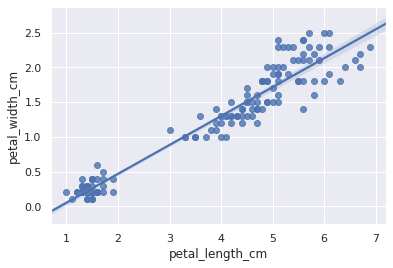

In [73]:
sns.regplot(x='petal_length_cm', y='petal_width_cm', data=df);

After the 

In [74]:
mx = np.max(df[df['class'] == 'Iris-setosa']['petal_length_cm'])
mn = np.min(df[df['class'] == 'Iris-versicolor']['petal_length_cm'])
print(mx, mn, mn-mx)

1.9 3.0 1.1


In [75]:
y = df['petal_width_cm']
x = df['petal_length_cm']
r = y / np.sin(np.arctan(y / x))
d = {'r': r, 'h': np.zeros(df.shape[0]), 'class': df['class']}
dfr = pd.DataFrame(data=d)
mx = np.max(dfr[dfr['class'] == 'Iris-setosa']['r'])
mn = np.min(dfr[dfr['class'] == 'Iris-versicolor']['r'])
print(mx, mn, mn-mx)

1.9416487838947596 3.1953090617340916 1.253660277839332


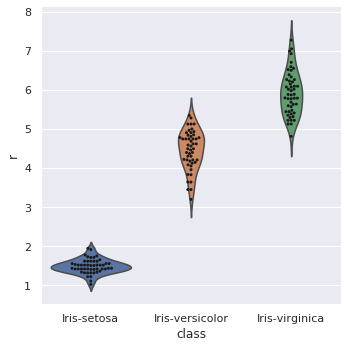

In [76]:
g = sns.catplot(x='class', y='r', kind='violin', inner=None, data=dfr);
sns.swarmplot(x='class', y='r', color='k', size=3, data=dfr, ax=g.ax);

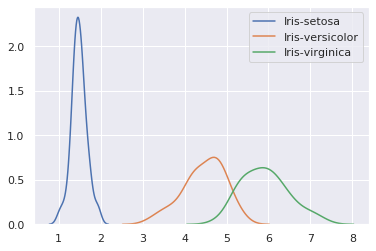

In [77]:
for c in pd.unique(dfr['class']):
    sns.kdeplot(dfr[dfr['class'] == c]['r'], label=c);

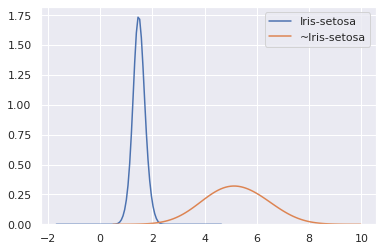

In [78]:
bw = 0.9
sns.kdeplot(dfr[dfr['class'] == 'Iris-setosa']['r'], bw=bw, label='Iris-setosa');
sns.kdeplot(dfr[dfr['class'] != 'Iris-setosa']['r'], bw=bw, label='~Iris-setosa');

In [79]:
X = df['petal_length_cm'].values[np.newaxis].T
y = df['petal_width_cm'].values[np.newaxis].T
print(X.shape, y.shape)
reg = LinearRegression().fit(X, y)
print(reg.coef_.flatten(), reg.intercept_)

(150, 1) (150, 1)
[0.41575542] [-0.36307552]


In [80]:
feature_set = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']
X = df[feature_set]
transformer = RobustScaler().fit(X)

result = mean_shift(transformer.transform(X))
print(a)

for ii, c in enumerate(result[1]):
    if c == 0:
        print(df['class'].iloc[ii])

NameError: name 'mean_shift' is not defined

In [0]:
result = dbscan(transformer.transform(X))
print(a)

for ii, c in enumerate(result[1]):
    if c == 1:
        print(df['class'].iloc[ii])